<a href="https://colab.research.google.com/github/DavisonDWilson/demographics-predictor/blob/main/Customer_Demographics_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A mobile phone operator created the dataset under review for a Kaggle [competition](https://www.kaggle.com/c/talkingdata-mobile-user-demographics). They wanted to understand their customers better. Specifically, they wanted to predict their user's gender and age data from usage data from their phones. The data comprise multiple files that need to be stitched together.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import itertools
from sklearn.decomposition import PCA
from sklearn import ensemble
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import preprocessing as prep
from sklearn.model_selection import cross_val_score, cross_val_predict
import warnings
warnings.filterwarnings("ignore")
from google.colab import drive
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest

The size of the datasets require speedy loading infrastructure, so the files were uploaded to google drive and pulled into the notebook from there.

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


The first file loaded contains information about the device_id, which uniquely identifies each device (and is assumed to correspond to each user), and the target variables: gender, age, and group. Group is a combination of gender and age-range.

In [ ]:
df = pd.read_csv('drive/My Drive/Thinkful/gender_age_train.csv')
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74645 entries, 0 to 74644
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   device_id  74645 non-null  int64 
 1   gender     74645 non-null  object
 2   age        74645 non-null  int64 
 3   group      74645 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.3+ MB
None
             device_id gender  age   group
0 -8076087639492063270      M   35  M32-38
1 -2897161552818060146      M   35  M32-38
2 -8260683887967679142      M   35  M32-38
3 -4938849341048082022      M   30  M29-31
4   245133531816851882      M   30  M29-31


The next file loaded contains the brand and model of phone for each device_id

In [ ]:
phone_df = pd.read_csv('drive/My Drive/Thinkful/phone_brand_device_model.csv')
print(phone_df.info())
print(phone_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187245 entries, 0 to 187244
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   device_id     187245 non-null  int64 
 1   phone_brand   187245 non-null  object
 2   device_model  187245 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.3+ MB
None
             device_id phone_brand   device_model
0 -8890648629457979026          小米             红米
1  1277779817574759137          小米           MI 2
2  5137427614288105724          三星      Galaxy S4
3  3669464369358936369       SUGAR           时尚手机
4 -5019277647504317457          三星  Galaxy Note 2


In [ ]:
df=df.join(phone_df.set_index('device_id'), on='device_id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74839 entries, 0 to 74644
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   device_id     74839 non-null  int64 
 1   gender        74839 non-null  object
 2   age           74839 non-null  int64 
 3   group         74839 non-null  object
 4   phone_brand   74839 non-null  object
 5   device_model  74839 non-null  object
dtypes: int64(2), object(4)
memory usage: 4.0+ MB


There are two other data files. The first contains information about app events. Every time a user would use the cell phone provider's api, information about the device would be recorded: which apps were installed and which were active. The second file links these events to device_ids. The data as provided is not suitable for use in training a model. It needs to be converted from information about apps and events into features of device_ids. The events file is sizeable and this data engineering was taking a long time to process in this notebook. To reduce run-time, the data transformation was done in more performant c# code. The code can be found at this [link](https://docs.google.com/document/d/1cgDc9YA5-4aUG1Sb6e6Mx1n9yRL-ZApQ61QlaaSsaOU/edit?usp=sharing). 

In summary, each app was characterized from the event data. The percentage of events for a given app that were created by men was calculated. Likewise, the percentage of events for each app that were created by each age of user was calculated. This data was calculated to characterize the usage of apps. Were they used more by men or women? Older users or younger ones?

Once that was done, the device_ids themselves were characterized. For each device_id, a feature was added representing the average of the apps' gender and age characterization weighted by the number of events for each app. The result is the "device_summary" file loaded below.

In [ ]:
df_device_summary = pd.read_csv('drive/My Drive/Thinkful/device_summary.csv')
print(df_device_summary.info())
print(df_device_summary.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23290 entries, 0 to 23289
Columns: 178 entries, device_id to Active_Age_89
dtypes: float64(169), int64(7), object(2)
memory usage: 31.6+ MB
None
             device_id gender  age   group  Min_Age  Max_Age  Total_Events  \
0  1476664663289716375      M   19    M22-       11       89       2538625   
1  7166563712658305181      M   60    M39+       11       89       1972722   
2 -3449419341168524142      M   28  M27-28       11       89       1915806   
3 -6542093539413689868      M   26  M23-26       11       89       2235840   
4 -5638521260975573107      M   22    M22-       11       89       1225764   

   Number_Male  Number_M_22  Number_M23_26  ...  Active_Age_80  Active_Age_81  \
0     0.710134     0.057139       0.115266  ...       0.000087       0.000037   
1     0.707804     0.054214       0.113969  ...       0.000095       0.000047   
2     0.708953     0.060017       0.117022  ...       0.000085       0.000044   
3     0.7244

In [ ]:
df_device_summary=df_device_summary.join(phone_df.set_index('device_id'), on='device_id')
df_device_summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23381 entries, 0 to 23289
Columns: 180 entries, device_id to device_model
dtypes: float64(169), int64(7), object(4)
memory usage: 32.3+ MB


In [ ]:
df_device_summary.head()

,device_id,gender,age,group,Min_Age,Max_Age,Total_Events,Number_Male,Number_M_22,Number_M23_26,...,Active_Age_82,Active_Age_83,Active_Age_84,Active_Age_85,Active_Age_86,Active_Age_87,Active_Age_88,Active_Age_89,phone_brand,device_model
0,1476664663289716375,M,19,M22-,11,89,2538625,0.710134,0.057139,0.115266,...,0.000080,0.000102,0,0.000009,0.000001,0.000002,0.000103,7.878281e-07,华为,Mate 7
1,7166563712658305181,M,60,M39+,11,89,1972722,0.707804,0.054214,0.113969,...,0.000093,0.000145,0,0.000009,0.000002,0.000002,0.000113,1.013828e-06,华为,荣耀畅玩4C
2,-3449419341168524142,M,28,M27-28,11,89,1915806,0.708953,0.060017,0.117022,...,0.000068,0.000094,0,0.000009,0.000002,0.000002,0.000113,1.565921e-06,华为,荣耀3X畅玩版
3,-6542093539413689868,M,26,M23-26,11,89,2235840,0.724435,0.060548,0.124345,...,0.000068,0.000098,0,0.000014,0.000001,0.000002,0.000109,8.945184e-07,华为,荣耀畅玩4X
4,-5638521260975573107,M,22,M22-,11,89,1225764,0.726986,0.064079,0.125190,...,0.000022,0.000051,0,0.000016,0.000000,0.000000,0.000055,0.000000e+00,华为,荣耀7


In [ ]:
training_data, testing_data = train_test_split(df_device_summary, test_size=0.2, random_state=1)
X_train = training_data.drop(['gender', 'age', 'group', 'device_id', 'phone_brand', 'device_model'], axis = 1)
X_test = testing_data.drop(['gender', 'age', 'group', 'device_id', 'phone_brand', 'device_model'], axis = 1)
y_train = training_data['group']
y_test = testing_data['group']

Min max scaling normalizes the data then PCA reduces the number of features. The first four features contain 76% of the variance.

In [ ]:
min_max_scaler = prep.MinMaxScaler()
df_scaled = pd.DataFrame(min_max_scaler.fit_transform(X_train))
pca = PCA(n_components=4)
pca_components = pca.fit_transform(df_scaled)
pca.explained_variance_ratio_

array([0.38978431, 0.2120242 , 0.10684807, 0.05309158])

The PCA components are added to the training_data to match up with the phone brand and device model. These are categorical data which were excluded from the PCA process but are desired for the final analysis.

In [ ]:
training_data['PCA1'] = pca_components[:,0]
training_data['PCA2'] = pca_components[:,1]
training_data['PCA3'] = pca_components[:,2]
training_data['PCA4'] = pca_components[:,3]

In [ ]:
def plot_confusion_matrix(cm, classes,normalize,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def eval_model(model, X, y, cv_num):
  scores = cross_val_score(model, X, y, cv=cv_num)
  predicted = cross_val_predict(model, X, y, cv=cv_num)
  cm = confusion_matrix(y, predicted)

  print("cross val scores: {}".format(scores))
  print("variance of cross val scores: {}".format(scores.var()))
  print("classification_report: {}".format(classification_report(y, predicted)))
  plot_confusion_matrix(cm,[0,1],False)

The principal components and the two categorical values are added to a dataframe. The categorical data are then one-hot encoded and stored in X_final.

In [ ]:
X_PCAd = training_data[['phone_brand', 'device_model', 'PCA1', 'PCA2', 'PCA3', 'PCA4']]
X_PCAd = pd.concat([X_PCAd,pd.get_dummies(X_PCAd['phone_brand'], prefix='phone_brand', drop_first=True)], axis=1)
X_PCAd = pd.concat([X_PCAd,pd.get_dummies(X_PCAd['device_model'], prefix='device_model', drop_first=True)], axis=1)
X_final = X_PCAd.drop(['phone_brand', 'device_model'], axis=1)

cross val scores: [0.19828968 0.17210048 0.17851416 0.16194548 0.17700535 0.15668449
 0.16524064 0.1684492  0.18823529 0.17593583]
variance of cross val scores: 0.0001381497420050547
classification_report:               precision    recall  f1-score   support

        F23-       0.18      0.17      0.17      1102
      F24-26       0.08      0.06      0.07       918
      F27-28       0.04      0.02      0.03       736
      F29-32       0.09      0.06      0.07      1103
      F33-42       0.14      0.12      0.13      1470
        F43+       0.12      0.08      0.09      1083
        M22-       0.19      0.20      0.20      1532
      M23-26       0.19      0.22      0.20      2216
      M27-28       0.12      0.09      0.10      1375
      M29-31       0.13      0.12      0.13      1981
      M32-38       0.19      0.24      0.21      2671
        M39+       0.24      0.35      0.29      2517

    accuracy                           0.17     18704
   macro avg       0.14      0.14   

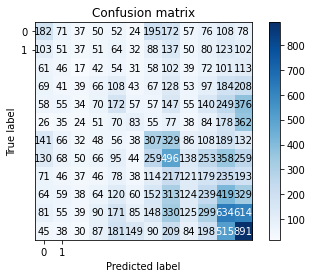

In [ ]:
rfc_grid = ensemble.RandomForestClassifier(n_estimators = 1000, n_jobs=-1, random_state=2)
eval_model(rfc_grid, X_final, y_train, 10 )

A random forest is used to model the data with some success. The weighted average f1 score is 16%. The final leader board in the kaggle competition was only 20%. However, the precision and recall varied dramatically between groups indicating that the model has serious issues.

cross val scores: [0.19722074 0.19454837 0.19935863 0.19134153 0.17860963 0.18502674
 0.19465241 0.21016043 0.20641711 0.19090909]
variance of cross val scores: 7.823653194906387e-05
classification_report:               precision    recall  f1-score   support

        F23-       0.18      0.19      0.19      1102
      F24-26       0.10      0.02      0.04       918
      F27-28       0.20      0.01      0.02       736
      F29-32       0.08      0.01      0.02      1103
      F33-42       0.13      0.07      0.09      1470
        F43+       0.11      0.02      0.03      1083
        M22-       0.20      0.23      0.21      1532
      M23-26       0.19      0.32      0.24      2216
      M27-28       0.06      0.01      0.01      1375
      M29-31       0.13      0.07      0.09      1981
      M32-38       0.19      0.34      0.24      2671
        M39+       0.25      0.45      0.32      2517

    accuracy                           0.19     18704
   macro avg       0.15      0.15   

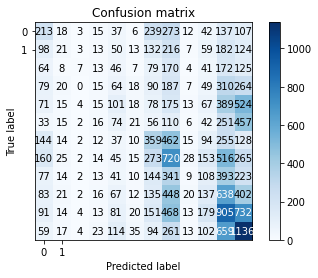

In [ ]:
lr = LogisticRegression(solver='lbfgs', penalty = 'l2',random_state=2, max_iter=10000)
lr.fit(X_final, y_train)
eval_model(lr,X_final, y_train, 10)
print('{} iterations out of {}'.format(lr.n_iter_[0], lr.max_iter))

The logistic regression model had slightly higher average recall but identical average f1-score and significantly more variation between groups. Because of the higher variability, this model is worse than the random forest model.

cross val scores: [0.20309995 0.20363442 0.20737573 0.18118653 0.18181818 0.17112299
 0.19197861 0.20053476 0.20374332 0.19090909]
variance of cross val scores: 0.00013396427225057393
classification_report:               precision    recall  f1-score   support

        F23-       0.17      0.19      0.18      1102
      F24-26       0.13      0.02      0.03       918
      F27-28       0.11      0.01      0.01       736
      F29-32       0.07      0.01      0.01      1103
      F33-42       0.12      0.04      0.06      1470
        F43+       0.11      0.01      0.01      1083
        M22-       0.19      0.19      0.19      1532
      M23-26       0.19      0.35      0.24      2216
      M27-28       0.07      0.00      0.01      1375
      M29-31       0.12      0.05      0.07      1981
      M32-38       0.18      0.37      0.24      2671
        M39+       0.25      0.46      0.32      2517

    accuracy                           0.19     18704
   macro avg       0.14      0.14  

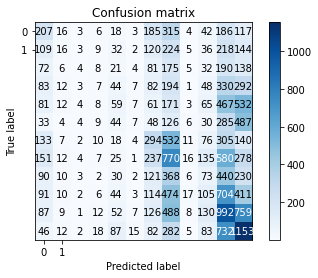

In [ ]:
svc = SVC(kernel='rbf')
eval_model(svc, X_final, y_train, 10)

The SVC model also has elevated inter-group variation compared to the random forest, and similar average accuracy, so is judged inferior.

In [ ]:
y_train_gender = training_data['gender']
y_test_gender = testing_data['gender']

cross val scores: [0.66648851 0.65312667 0.66702298 0.6525922  0.65561497 0.64812834
 0.66951872 0.64331551 0.65454545 0.67593583]
variance of cross val scores: 9.875882492737973e-05
classification_report:               precision    recall  f1-score   support

           F       0.50      0.28      0.36      6412
           M       0.70      0.85      0.77     12292

    accuracy                           0.66     18704
   macro avg       0.60      0.57      0.56     18704
weighted avg       0.63      0.66      0.63     18704

Confusion matrix, without normalization


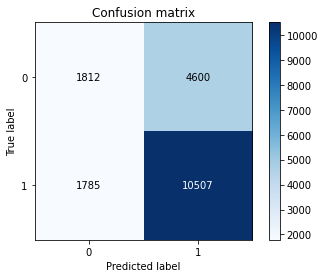

In [ ]:
rfc_grid = ensemble.RandomForestClassifier(n_estimators = 1000, n_jobs=-1, random_state=2)
eval_model(rfc_grid, X_final, y_train_gender, 10 )

Predicting gender is far easier. The model has a much higher average f1 score (.63) than those predicting groups. This model is more reasonable but still has high variability between the categories.

In [ ]:
y_train_age = training_data['age']
y_test_age = testing_data['age']

cross val scores: [0.05718867 0.04917157 0.05344735 0.05130946 0.05187166 0.05240642
 0.05187166 0.06256684 0.06203209 0.05989305]
variance of cross val scores: 2.114313961262111e-05
classification_report:               precision    recall  f1-score   support

          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         5
          15       0.00      0.00      0.00        10
          16       0.00      0.00      0.00        24
          17       0.13      0.10      0.12        67
          18       0.11      0.06      0.08       109
          19       0.06      0.05      0.06       366
          20       0.06      0.05      0.06       554
          21       0.07      0.07      0.07       617
          22       0.06      0.07      0.07       644
          23       0.06      0.06      0.06       691
          24       0.04      0.04    

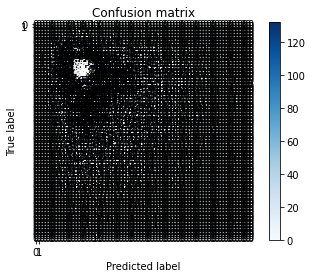

In [ ]:
rfc_grid = ensemble.RandomForestClassifier(n_estimators = 1000, n_jobs=-1, random_state=2)
eval_model(rfc_grid, X_final, y_train_age, 10 )

Trying to predict age was a disaster. This is clearly the aspect of the group that makes it so challenging to correctly predict. Oversampling will therefore be tried. Additionally, hyperparameters will be tuned using GridSearchCV.

In [ ]:
oversample = SMOTE()
X_group_smitten_train, y_group_smitten_train = oversample.fit_resample(X_final, y_train)

In [ ]:
parameters_svc = {'kernel':('linear', 'poly', 'rbf')}
svc_selected = SVC(random_state=2, max_iter=10000)
clf_svc = GridSearchCV(svc_selected, parameters_svc, n_jobs=-1)
clf_svc.fit(X_group_smitten_train, y_group_smitten_train)
clf_svc.best_params_

{'kernel': 'rbf'}

cross val scores: [0.19213974 0.19900187 0.18907956 0.19375975 0.23525741 0.22589704
 0.23962559 0.25117005 0.24087363 0.24056162]
variance of cross val scores: 0.0005339101496777659
classification_report:               precision    recall  f1-score   support

        F23-       0.24      0.38      0.29      2671
      F24-26       0.22      0.24      0.23      2671
      F27-28       0.22      0.33      0.26      2671
      F29-32       0.19      0.14      0.16      2671
      F33-42       0.21      0.20      0.20      2671
        F43+       0.26      0.31      0.28      2671
        M22-       0.25      0.28      0.26      2671
      M23-26       0.19      0.15      0.17      2671
      M27-28       0.19      0.15      0.16      2671
      M29-31       0.19      0.13      0.15      2671
      M32-38       0.17      0.09      0.12      2671
        M39+       0.26      0.25      0.25      2671

    accuracy                           0.22     32052
   macro avg       0.21      0.22   

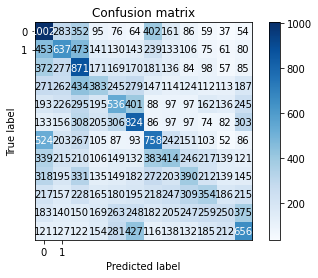

In [ ]:
svc = SVC(kernel='rbf')
eval_model(svc, X_group_smitten_train, y_group_smitten_train, 10)

Oversampling clearly improved accuracy. Not including the outlier group M32-28, the recall ranged from 13% - 35% with a weighted average of 22%.

In [ ]:
parameters_lr = {'solver':('liblinear','lbfgs'),'penalty':('none','l2')}
lr_selected = LogisticRegression(random_state=2, max_iter=10000)
clf_lr = GridSearchCV(lr_selected, parameters_lr, n_jobs=-1)
clf_lr.fit(X_group_smitten_train, y_group_smitten_train)
clf_lr.best_params_

{'penalty': 'none', 'solver': 'lbfgs'}

cross val scores: [0.18402994 0.18028696 0.17815913 0.18939158 0.20561622 0.20592824
 0.22558502 0.22059282 0.23088924 0.23151326]
variance of cross val scores: 0.00040554621405088423
classification_report:               precision    recall  f1-score   support

        F23-       0.24      0.33      0.28      2671
      F24-26       0.19      0.19      0.19      2671
      F27-28       0.20      0.23      0.21      2671
      F29-32       0.17      0.11      0.14      2671
      F33-42       0.20      0.19      0.20      2671
        F43+       0.24      0.30      0.26      2671
        M22-       0.22      0.32      0.27      2671
      M23-26       0.18      0.15      0.16      2671
      M27-28       0.18      0.15      0.16      2671
      M29-31       0.17      0.14      0.15      2671
      M32-38       0.17      0.12      0.14      2671
        M39+       0.22      0.24      0.23      2671

    accuracy                           0.21     32052
   macro avg       0.20      0.21  

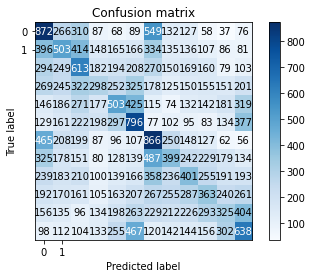

In [ ]:
lr_group = LogisticRegression(solver='lbfgs', penalty = 'none',random_state=2, max_iter=10000)
lr_group.fit(X_group_smitten_train, y_group_smitten_train)
eval_model(lr_group,X_group_smitten_train, y_group_smitten_train, 10)
print('{} iterations out of {}'.format(lr_group.n_iter_[0], lr_group.max_iter))

The logistic regression model had a tighter spread of group accuracy and similar averages, so its performance is better.

In [ ]:
parameters = {'n_estimators':[250, 500, 750, 1000]}
rfc_selected = ensemble.RandomForestClassifier(n_jobs=-1, random_state=2)
clf = GridSearchCV(rfc_selected, parameters, n_jobs=-1)
clf.fit(X_group_smitten_train, y_group_smitten_train)
clf.best_params_

{'n_estimators': 500}

cross val scores: [0.41484716 0.4095446  0.41279251 0.41092044 0.46926677 0.48424337
 0.51201248 0.54477379 0.57566303 0.60062402]
variance of cross val scores: 0.004743258210943647
classification_report:               precision    recall  f1-score   support

        F23-       0.56      0.67      0.61      2671
      F24-26       0.56      0.65      0.60      2671
      F27-28       0.56      0.68      0.62      2671
      F29-32       0.53      0.57      0.55      2671
      F33-42       0.49      0.51      0.50      2671
        F43+       0.53      0.65      0.59      2671
        M22-       0.53      0.56      0.54      2671
      M23-26       0.36      0.28      0.31      2671
      M27-28       0.49      0.52      0.50      2671
      M29-31       0.40      0.34      0.37      2671
      M32-38       0.22      0.13      0.16      2671
        M39+       0.32      0.26      0.28      2671

    accuracy                           0.48     32052
   macro avg       0.46      0.48    

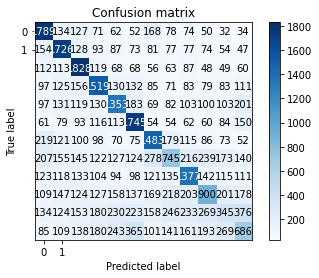

In [ ]:
rfc_grid2 = ensemble.RandomForestClassifier(n_estimators = 500, n_jobs=-1, random_state=2)
eval_model(rfc_grid2, X_group_smitten_train, y_group_smitten_train, 10 )

The random forest model with oversampling and hyperparameter tuning had high accuracy but also a high spread of its cv scores. There was also a big range in precision and recall between the groups. These factors drive concern that the model has been over-fit to the data. It is therefore considered a worse model than the logistic regression model, which is the best model reviewed. 

To verify the performance of the model, and to minimize the chance of overfitting, the model will now be validated with the test data reserved earlier. First, the same transformations applied to the training data will be applied to the test data. Note in the code block below min_max_scaler and pca use .transform not .fit_tranform so the applied transformations are the same as those applied to the training data.

In [ ]:
df_scaled_test = pd.DataFrame(min_max_scaler.transform(X_test))
pca_components_test = pca.transform(df_scaled_test)
testing_data['PCA1'] = pca_components_test[:,0]
testing_data['PCA2'] = pca_components_test[:,1]
testing_data['PCA3'] = pca_components_test[:,2]
testing_data['PCA4'] = pca_components_test[:,3]
X_PCAd_test = testing_data[['phone_brand', 'device_model', 'PCA1', 'PCA2', 'PCA3', 'PCA4']]
X_PCAd_test = pd.concat([X_PCAd_test,pd.get_dummies(X_PCAd_test['phone_brand'], prefix='phone_brand', drop_first=True)], axis=1)
X_PCAd_test = pd.concat([X_PCAd_test,pd.get_dummies(X_PCAd_test['device_model'], prefix='device_model', drop_first=True)], axis=1)
X_final_test = X_PCAd_test.drop(['phone_brand', 'device_model'], axis=1)

In [ ]:
rfc_grid2.fit(X_group_smitten_train, y_group_smitten_train)

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=2)

In [ ]:
print("training data columns: {}".format(X_group_smitten_train.shape[1]))
print("testing data columns: {}".format(X_final_test.shape[1]))

training data columns: 943
testing data columns: 606


Unfortunately the training and testing data don't have the same number of features. The test data set is missing some of the dummy features created from the original phone_brand and device_model features. The data set is clearly not large enough to capture all the relevant details of the underlying population. Since the test data doesn't contain any dummy features that the training data lacks, we can just re-index the test data with zeros. However, this is only a short term solution. In the long term, more data should be gathered to allow a more accurate model.

In [ ]:
X_final_test_reindexed = X_final_test.reindex(columns=X_group_smitten_train.columns, fill_value=0)

In [ ]:
print("training data columns: {}".format(X_group_smitten_train.shape[1]))
print("testing data columns: {}".format(X_final_test_reindexed.shape[1]))

training data columns: 943
testing data columns: 943


In [ ]:
lr_group2 = LogisticRegression(solver='lbfgs', penalty = 'none',random_state=2, max_iter=10000)

In [ ]:
lr_group2.fit(X_group_smitten_train, y_group_smitten_train)

LogisticRegression(max_iter=10000, penalty='none', random_state=2)

In [ ]:
lr_group2.score(X_final_test_reindexed, y_test)

0.15672439598032928

Despite the reasonably good cv scores, the model is clearly overfit causing it to have low accuracy on out-of-sample data. A significantly larger dataset should be collected to model the data. 